## Preprocessing

In [3]:


import os
import json
import numpy as np
from PIL import Image

kp_threshold = 0.1

image_folder = "../images/"
image_name = "sample.jpg"

pil_image = Image.open(image_folder+image_name)
im_width, im_height = pil_image.size
np_image = np.array(pil_image)

fx=2304.54786556982
fy=2305.875668062
cx=1686.23787612802
cy=1354.98486439791

camera_matrix = np.array([[fx, 0,  cx],
                          [0,  fy, cy],
                          [0,  0,  1 ]], dtype=np.float32)

dist_coeffs = np.zeros((1,4))

## Detect vehicle box and mask

### call detectron2 API to get the mask of vehicle

In [13]:
import sys
sys.path.append("./wlevel_estimator")
import wlevel_estimator


ModuleNotFoundError: No module named 'wlevel_estimator'

### segment each vehicle image

### Example

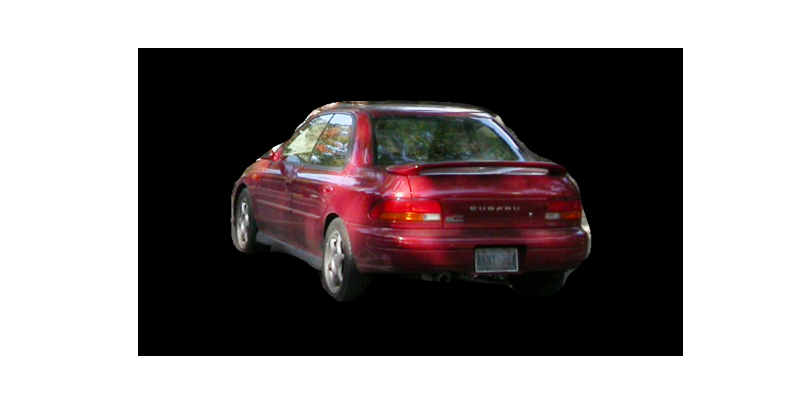

In [46]:
%matplotlib widget
car = cars[0]
image = car.np_image
mask = car.mask

image_masked = apply_mask_np(image,mask)

plt.figure(figsize=(8,4))
plt.axis("off")
plt.imshow(image_masked)
plt.show()


## Detect vehicle Keypoint

### CLI WAY

In [48]:
os.system("python -m openpifpaf.predict " + image_folder + image_name + \
  " --checkpoint=shufflenetv2k16-apollo-24 --json-output ./json \
  --instance-threshold 0.05 --seed-threshold 0.05 \
  --line-width 4 --font-size 0")

with open("../json/"+image_name+".predictions.json") as file:
    vehicles = json.load(file)

### In code Way

## Calculate Transform

In [98]:
with open("../mesh/dazhong_24keypts.txt") as file:
    keypoints_3D_24 = []
    
    for line in file.readlines():
        line = line.strip('\n')
        x,y,score = line.split()
        keypoints_3D_24.append(line.split())

In [134]:
def get_transform(car,keypoints_3D_24):
    keypoints_2D = car.keypoints

    index = car.visable_id

    keypoints_3D_24_ndarray = np.array(keypoints_3D_24)
    keypoints_3D = keypoints_3D_24_ndarray[index].tolist()

    objPoints = np.array(keypoints_3D,dtype='float64')
    imgPoints = np.array(keypoints_2D,dtype='float64')

    (_, rotation_vector, translation_vector) = cv2.solvePnP(objPoints,
                                                            imgPoints,
                                                            camera_matrix,
                                                            dist_coeffs,
                                                            useExtrinsicGuess=False,flags=cv2.SOLVEPNP_ITERATIVE
                                                            )
    car.set_transform(rotation_vector, translation_vector)

In [135]:
for car in cars:
    get_transform(car,keypoints_3D_24)

## Render car mesh

### Load mesh

In [116]:
with open("../mesh/dazhong.json") as json_file:
        car_model = json.load(json_file)

vertices = np.array(car_model['vertices'])  # x: w y: h z: l
triangles = np.array(car_model['faces']) - 1


### Render

In [119]:
def draw_obj(image, vertices, triangles, color):
    for t in triangles:
        coord = np.array(
            [vertices[t[0]][:2], vertices[t[1]][:2],
                vertices[t[2]][:2]], dtype=np.int32
        )
        cv2.polylines(image, np.int32([coord]), 1, color)
        
def draw_obj_mask(image, vertices, triangles, color):
    for t in triangles:
        coord = np.array(
            [vertices[t[0]][:2], vertices[t[1]][:2],
                vertices[t[2]][:2]], dtype=np.int32
        )
        cv2.fillPoly(image, np.int32([coord]),  color)

In [136]:
images = []
for car in cars:
    rotation_vector = car.rotation_vector
    translation_vector = car.translation_vector
    image = np.copy(car.np_image)
    (projected_point2D_model, jacobian_model) = cv2.projectPoints(vertices, 
                                                                rotation_vector, 
                                                                translation_vector,
                                                                camera_matrix, 
                                                                dist_coeffs)
    draw_obj_mask(image,projected_point2D_model,triangles,(0, 125, 255))
    images.append(image)

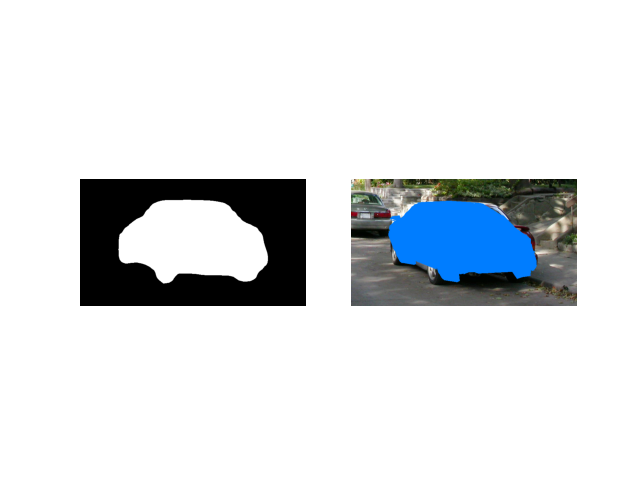

In [137]:
plt.figure()
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(cars[2].mask,cmap='gray')
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(images[2])
plt.show()

## Calculate the water level